# The Original Code

In [ ]:
import random
from copy import copy, deepcopy
import csv
import matplotlib.pyplot as plt

EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']
def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))

def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

def gameover(state):
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1

def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)

class Agent(object):
    def __init__(self, player, verbose = False, lossval = 0, learning = True):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = 0.99
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        # elif winner == DRAW:
        #     return 0
        # else:
        #     return self.lossval
        else:
            return 0

    def printvalues(self):
        vals = deepcopy(self.values)
        for key in vals:
            state = [list(key[0]),list(key[1]),list(key[2])]
            cells = []
            for i in range(3):
                for j in range(3):
                    if state[i][j] == EMPTY:
                        state[i][j] = self.player
                        cells.append(str(self.lookup(state)).center(3))
                        state[i][j] = EMPTY
                    else:
                        cells.append(NAMES[state[i][j]].center(3))
            print(BOARD_FORMAT.format(*cells))

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)

class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        action = input('Your move? i.e. x,y : ')
        return (int(action.split(',')[0]),int(action.split(',')[1]))

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))

def play(agent1, agent2):
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner

def measure_performance_vs_random(agent1, agent2):
    epsilon1 = agent1.epsilon
    epsilon2 = agent2.epsilon
    agent1.epsilon = 0
    agent2.epsilon = 0
    agent1.learning = False
    agent2.learning = False
    r1 = Agent(1)
    r2 = Agent(2)
    r1.epsilon = 1
    r2.epsilon = 1
    probs = [0,0,0,0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, r2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    for i in range(games):
        winner = play(r1, agent2)
        if winner == PLAYER_O:
            probs[3] += 1.0 / games
        elif winner == PLAYER_X:
            probs[4] += 1.0 / games
        else:
            probs[5] += 1.0 / games
    agent1.epsilon = epsilon1
    agent2.epsilon = epsilon2
    agent1.learning = True
    agent2.learning = True
    return probs

def measure_performance_vs_each_other(agent1, agent2):
    #epsilon1 = agent1.epsilon
    #epsilon2 = agent2.epsilon
    #agent1.epsilon = 0
    #agent2.epsilon = 0
    #agent1.learning = False
    #agent2.learning = False
    probs = [0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, agent2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    #agent1.epsilon = epsilon1
    #agent2.epsilon = epsilon2
    #agent1.learning = True
    #agent2.learning = True
    return probs

if __name__ == "__main__":
    p1 = Agent(1, lossval = -1)
    p2 = Agent(2, lossval = -1)
    r1 = Agent(1, learning = False)
    r2 = Agent(2, learning = False)
    r1.epsilon = 1
    r2.epsilon = 1
    series = ['P1-Win','P1-Lose','P1-Draw','P2-Win','P2-Lose','P2-Draw']
    #series = ['P1-Win', 'P2-Win', 'Draw']
    colors = ['r','b','g','c','m','b']
    markers = ['+', '.', 'o', '*', '^', 's']
    f = open('results.csv', 'w')
    writer = csv.writer(f)
    writer.writerow(series)
    perf = [[] for _ in range(len(series) + 1)]
    for i in range(10000):
        if i % 100 == 0:
            print('Game: {0}'.format(i))
            probs = measure_performance_vs_random(p1, p2)
            writer.writerow(probs)
            f.flush()
            perf[0].append(i)
            for idx,x in enumerate(probs):
                perf[idx+1].append(x)
        winner = play(p1,p2)
        p1.episode_over(winner)
        #winner = play(r1,p2)
        p2.episode_over(winner)
    f.close()
    for i in range(1,len(perf)):
        plt.plot(perf[0], perf[i], label=series[i-1], color=colors[i-1])
    plt.xlabel('Episodes')
    plt.ylabel('Probability')
    plt.title('RL Agent Performance vs. Random Agent\n({0} loss value, self-play)'.format(p1.lossval))
    #plt.title('P1 Loss={0} vs. P2 Loss={1}'.format(p1.lossval, p2.lossval))
    plt.legend()
    plt.show()
    #plt.savefig('p1loss{0}vsp2loss{1}.png'.format(p1.lossval, p2.lossval))
    plt.savefig('selfplay_random_{0}loss.png'.format(p1.lossval))
    while True:
        p2.verbose = True
        p1 = Human(1)
        winner = play(p1,p2)
        p1.episode_over(winner)
        p2.episode_over(winner)

#  Draw = 0, Loss = 0, Win = 1


Learning Rate: 0.1, Episode: 1000
Learning Rate: 0.1, Episode: 2000
Learning Rate: 0.1, Episode: 3000
Learning Rate: 0.1, Episode: 4000
Learning Rate: 0.1, Episode: 5000
Learning Rate: 0.1, Episode: 6000
Learning Rate: 0.1, Episode: 7000
Learning Rate: 0.1, Episode: 8000
Learning Rate: 0.1, Episode: 9000
Learning Rate: 0.1, Episode: 10000
Overall Win Percentage for Player X at α = 0.1: 81.56%
Overall Loss Percentage for Player X at α = 0.1: 10.19%
Overall Draw Percentage at α = 0.1: 8.25%
Learning Rate: 0.3, Episode: 1000
Learning Rate: 0.3, Episode: 2000
Learning Rate: 0.3, Episode: 3000
Learning Rate: 0.3, Episode: 4000
Learning Rate: 0.3, Episode: 5000
Learning Rate: 0.3, Episode: 6000
Learning Rate: 0.3, Episode: 7000
Learning Rate: 0.3, Episode: 8000
Learning Rate: 0.3, Episode: 9000
Learning Rate: 0.3, Episode: 10000
Overall Win Percentage for Player X at α = 0.3: 84.45%
Overall Loss Percentage for Player X at α = 0.3: 9.55%
Overall Draw Percentage at α = 0.3: 6.00%
Learning Rate

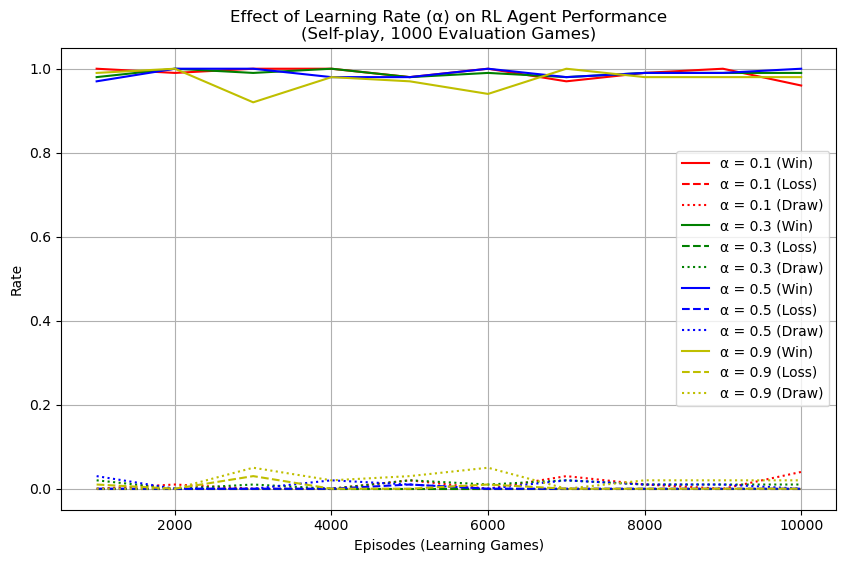

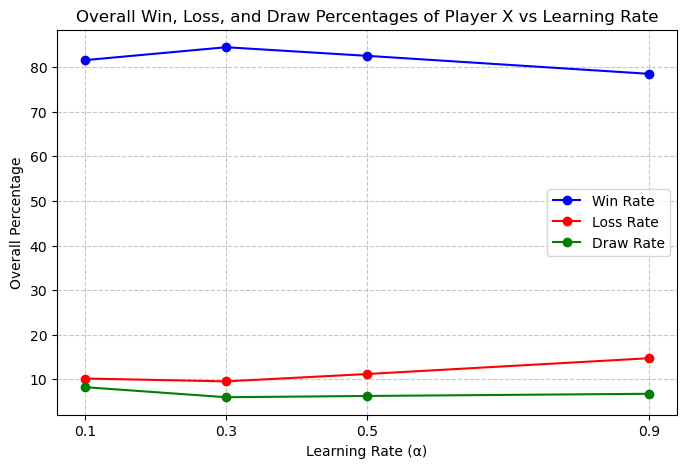

In [26]:
import random
from copy import copy, deepcopy
import csv
import matplotlib.pyplot as plt

EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']
def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))

def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

def gameover(state):
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1

def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)

class Agent(object):
    def __init__(self, player, verbose = False, lossval = 0, learning = True, alpha = 0.99):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = alpha
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        else:
            return 0

    def printvalues(self):
        vals = deepcopy(self.values)
        for key in vals:
            state = [list(key[0]),list(key[1]),list(key[2])]
            cells = []
            for i in range(3):
                for j in range(3):
                    if state[i][j] == EMPTY:
                        state[i][j] = self.player
                        cells.append(str(self.lookup(state)).center(3))
                        state[i][j] = EMPTY
                    else:
                        cells.append(NAMES[state[i][j]].center(3))
            print(BOARD_FORMAT.format(*cells))

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)

class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        action = input('Your move? i.e. x,y : ')
        return (int(action.split(',')[0]),int(action.split(',')[1]))

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))

def play(agent1, agent2):
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner

def measure_performance_vs_random(agent1, agent2):
    epsilon1 = agent1.epsilon
    epsilon2 = agent2.epsilon
    agent1.epsilon = 0
    agent2.epsilon = 0
    agent1.learning = False
    agent2.learning = False
    r1 = Agent(1)
    r2 = Agent(2)
    r1.epsilon = 1
    r2.epsilon = 1
    probs = [0,0,0,0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, r2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    for i in range(games):
        winner = play(r1, agent2)
        if winner == PLAYER_O:
            probs[3] += 1.0 / games
        elif winner == PLAYER_X:
            probs[4] += 1.0 / games
        else:
            probs[5] += 1.0 / games
    agent1.epsilon = epsilon1
    agent2.epsilon = epsilon2
    agent1.learning = True
    agent2.learning = True
    return probs

def measure_performance_vs_each_other(agent1, agent2):
    #epsilon1 = agent1.epsilon
    #epsilon2 = agent2.epsilon
    #agent1.epsilon = 0
    #agent2.epsilon = 0
    #agent1.learning = False
    #agent2.learning = False
    probs = [0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, agent2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    #agent1.epsilon = epsilon1
    #agent2.epsilon = epsilon2
    #agent1.learning = True
    #agent2.learning = True
    return probs

if __name__ == "__main__":
    learning_rates = [0.1, 0.3, 0.5, 0.9]  # Different learning rates to test
    colors = ['r', 'g', 'b', 'y']  # Colors for each learning rate

    num_episodes = 10000  # Total number of learning episodes
    evaluation_interval = 1000  # Evaluate every 1000 episodes

    plt.figure(figsize=(10, 6))
    overall_win_percentages = []
    overall_loss_percentages = []
    overall_draw_percentages = []

    for idx, alpha in enumerate(learning_rates):
        p1 = Agent(1, lossval=0, alpha=alpha)  # Player X with specific learning rate
        p2 = Agent(2, lossval=0, alpha=alpha)  # Player O with specific learning rate
        r1 = Agent(1, learning=False)  # Random agent for Player X
        r2 = Agent(2, learning=False)  # Random agent for Player O
        r1.epsilon = 1  # Always random
        r2.epsilon = 1  # Always random

        perf = [[] for _ in range(4)]  # perf[0]: Episodes, perf[1]: Player_X Win Rate, perf[2]: Player_X Loss Rate, perf[3]: Draw Rate
        total_p1_wins = 0
        total_p1_losses = 0
        total_draws = 0
        total_games = 0

        for i in range(num_episodes):
            # Self-play for learning
            winner = play(p1, p2)
            p1.episode_over(winner)
            p2.episode_over(winner)

            if winner == PLAYER_X:
                total_p1_wins += 1
            elif winner == PLAYER_O:
                total_p1_losses += 1
            else:
                total_draws += 1
            total_games += 1

            # Evaluate Player_X against a random agent (r2) every 100 episodes
            if (i + 1) % evaluation_interval == 0:  # Evaluate every 100 episodes
                print(f'Learning Rate: {alpha}, Episode: {i + 1}')
                probs = measure_performance_vs_random(p1, p2)
                p1_win_rate = probs[0]  # P1-Win is the first element
                p1_loss_rate = probs[1]  # P1-Loss is the second element
                draw_rate = probs[2]  # Draw is the third element
                perf[0].append(i + 1)  # Episode number
                perf[1].append(p1_win_rate)  # Player_X win rate
                perf[2].append(p1_loss_rate)  # Player_X loss rate
                perf[3].append(draw_rate)  # Draw rate

        overall_p1_win_percentage = (total_p1_wins / total_games) * 100
        overall_p1_loss_percentage = (total_p1_losses / total_games) * 100
        overall_draw_percentage = (total_draws / total_games) * 100
        overall_win_percentages.append(overall_p1_win_percentage)
        overall_loss_percentages.append(overall_p1_loss_percentage)
        overall_draw_percentages.append(overall_draw_percentage)
        print(f'Overall Win Percentage for Player X at α = {alpha}: {overall_p1_win_percentage:.2f}%')
        print(f'Overall Loss Percentage for Player X at α = {alpha}: {overall_p1_loss_percentage:.2f}%')
        print(f'Overall Draw Percentage at α = {alpha}: {overall_draw_percentage:.2f}%')

        # Plot Player_X Win Rate, Loss Rate, and Draw Rate vs Episodes for this learning rate
        plt.plot(perf[0], perf[1], label=f'α = {alpha} (Win)', color=colors[idx])
        plt.plot(perf[0], perf[2], label=f'α = {alpha} (Loss)', color=colors[idx], linestyle='--')
        plt.plot(perf[0], perf[3], label=f'α = {alpha} (Draw)', color=colors[idx], linestyle=':')

    # Finalize plot for win rate vs episodes
    plt.xlabel('Episodes (Learning Games)')
    plt.ylabel('Rate')
    plt.title('Effect of Learning Rate (α) on RL Agent Performance\n(Self-play, 1000 Evaluation Games)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(learning_rates, overall_win_percentages, marker='o', linestyle='-', color='b', label='Win Rate')
    plt.plot(learning_rates, overall_loss_percentages, marker='o', linestyle='-', color='r', label='Loss Rate')
    plt.plot(learning_rates, overall_draw_percentages, marker='o', linestyle='-', color='g', label='Draw Rate')
    
    # Labels and title
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Overall Percentage')
    plt.title('Overall Win, Loss, and Draw Percentages of Player X vs Learning Rate')
    
    # Grid and formatting
    plt.xticks(learning_rates)  # Ensures learning rates appear correctly on x-axis
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.show()
    # print("\nNow you can play against the trained AI (Player O)!")
    # while True:
    #     p2.verbose = True  # Make AI print board states
    #     p1 = Human(1)  # Human plays as Player X
    #     winner = play(p1, p2)  # Play a game
    #     p1.episode_over(winner)  # Display result
    #     p2.episode_over(winner)  # AI learns from the game


#  Draw = 0, Loss = -0.5, Win = 1


Learning Rate: 0.1, Episode: 1000
Learning Rate: 0.1, Episode: 2000
Learning Rate: 0.1, Episode: 3000
Learning Rate: 0.1, Episode: 4000
Learning Rate: 0.1, Episode: 5000
Learning Rate: 0.1, Episode: 6000
Learning Rate: 0.1, Episode: 7000
Learning Rate: 0.1, Episode: 8000
Learning Rate: 0.1, Episode: 9000
Learning Rate: 0.1, Episode: 10000
Overall Win Percentage for Player X at α = 0.1: 50.41%
Overall Loss Percentage for Player X at α = 0.1: 19.84%
Overall Draw Percentage at α = 0.1: 29.75%
Learning Rate: 0.3, Episode: 1000
Learning Rate: 0.3, Episode: 2000
Learning Rate: 0.3, Episode: 3000
Learning Rate: 0.3, Episode: 4000
Learning Rate: 0.3, Episode: 5000
Learning Rate: 0.3, Episode: 6000
Learning Rate: 0.3, Episode: 7000
Learning Rate: 0.3, Episode: 8000
Learning Rate: 0.3, Episode: 9000
Learning Rate: 0.3, Episode: 10000
Overall Win Percentage for Player X at α = 0.3: 45.45%
Overall Loss Percentage for Player X at α = 0.3: 19.36%
Overall Draw Percentage at α = 0.3: 35.19%
Learning R

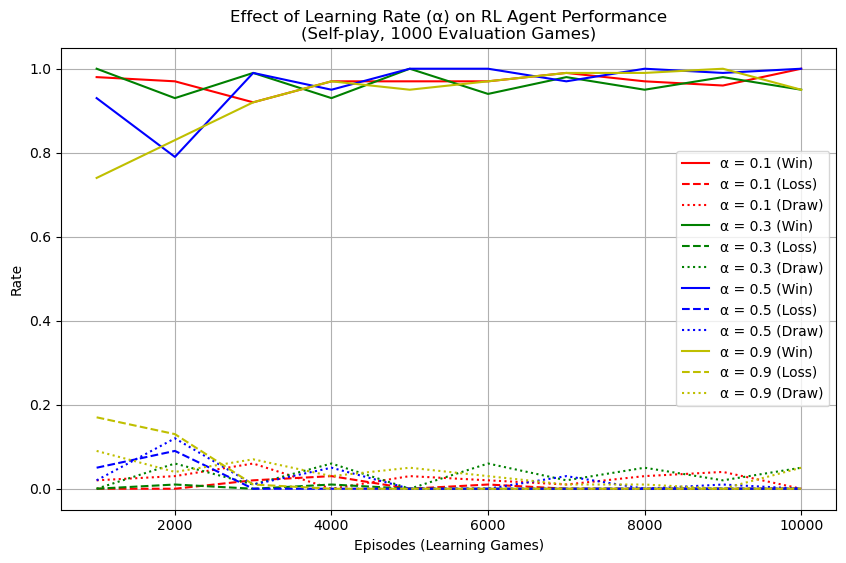

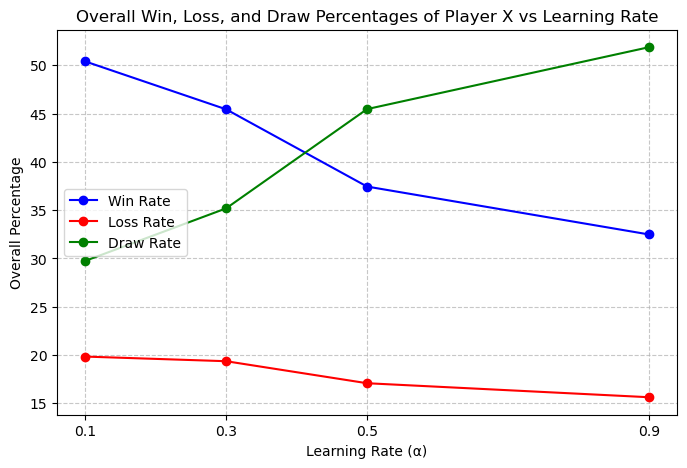

In [28]:
import random
from copy import copy, deepcopy
import csv
import matplotlib.pyplot as plt

EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']
def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))

def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

def gameover(state):
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1

def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)

class Agent(object):
    def __init__(self, player, verbose = False, lossval = -0.5, learning = True, alpha = 0.99):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = alpha
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return -0.5

    def printvalues(self):
        vals = deepcopy(self.values)
        for key in vals:
            state = [list(key[0]),list(key[1]),list(key[2])]
            cells = []
            for i in range(3):
                for j in range(3):
                    if state[i][j] == EMPTY:
                        state[i][j] = self.player
                        cells.append(str(self.lookup(state)).center(3))
                        state[i][j] = EMPTY
                    else:
                        cells.append(NAMES[state[i][j]].center(3))
            print(BOARD_FORMAT.format(*cells))

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)

class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        action = input('Your move? i.e. x,y : ')
        return (int(action.split(',')[0]),int(action.split(',')[1]))

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))

def play(agent1, agent2):
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner

def measure_performance_vs_random(agent1, agent2):
    epsilon1 = agent1.epsilon
    epsilon2 = agent2.epsilon
    agent1.epsilon = 0
    agent2.epsilon = 0
    agent1.learning = False
    agent2.learning = False
    r1 = Agent(1)
    r2 = Agent(2)
    r1.epsilon = 1
    r2.epsilon = 1
    probs = [0,0,0,0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, r2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    for i in range(games):
        winner = play(r1, agent2)
        if winner == PLAYER_O:
            probs[3] += 1.0 / games
        elif winner == PLAYER_X:
            probs[4] += 1.0 / games
        else:
            probs[5] += 1.0 / games
    agent1.epsilon = epsilon1
    agent2.epsilon = epsilon2
    agent1.learning = True
    agent2.learning = True
    return probs

def measure_performance_vs_each_other(agent1, agent2):
    #epsilon1 = agent1.epsilon
    #epsilon2 = agent2.epsilon
    #agent1.epsilon = 0
    #agent2.epsilon = 0
    #agent1.learning = False
    #agent2.learning = False
    probs = [0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, agent2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    #agent1.epsilon = epsilon1
    #agent2.epsilon = epsilon2
    #agent1.learning = True
    #agent2.learning = True
    return probs

if __name__ == "__main__":
    learning_rates = [0.1, 0.3, 0.5, 0.9]  # Different learning rates to test
    colors = ['r', 'g', 'b', 'y']  # Colors for each learning rate

    num_episodes = 10000  # Total number of learning episodes
    evaluation_interval = 1000  # Evaluate every 1000 episodes

    plt.figure(figsize=(10, 6))
    overall_win_percentages = []
    overall_loss_percentages = []
    overall_draw_percentages = []

    for idx, alpha in enumerate(learning_rates):
        p1 = Agent(1, lossval=- 0.5, alpha=alpha)  # Player X with specific learning rate
        p2 = Agent(2, lossval=- 0.5, alpha=alpha)  # Player O with specific learning rate
        r1 = Agent(1, learning=False)  # Random agent for Player X
        r2 = Agent(2, learning=False)  # Random agent for Player O
        r1.epsilon = 1  # Always random
        r2.epsilon = 1  # Always random

        perf = [[] for _ in range(4)]  # perf[0]: Episodes, perf[1]: Player_X Win Rate, perf[2]: Player_X Loss Rate, perf[3]: Draw Rate
        total_p1_wins = 0
        total_p1_losses = 0
        total_draws = 0
        total_games = 0

        for i in range(num_episodes):
            # Self-play for learning
            winner = play(p1, p2)
            p1.episode_over(winner)
            p2.episode_over(winner)

            if winner == PLAYER_X:
                total_p1_wins += 1
            elif winner == PLAYER_O:
                total_p1_losses += 1
            else:
                total_draws += 1
            total_games += 1

            # Evaluate Player_X against a random agent (r2) every 100 episodes
            if (i + 1) % evaluation_interval == 0:  # Evaluate every 100 episodes
                print(f'Learning Rate: {alpha}, Episode: {i + 1}')
                probs = measure_performance_vs_random(p1, p2)
                p1_win_rate = probs[0]  # P1-Win is the first element
                p1_loss_rate = probs[1]  # P1-Loss is the second element
                draw_rate = probs[2]  # Draw is the third element
                perf[0].append(i + 1)  # Episode number
                perf[1].append(p1_win_rate)  # Player_X win rate
                perf[2].append(p1_loss_rate)  # Player_X loss rate
                perf[3].append(draw_rate)  # Draw rate

        overall_p1_win_percentage = (total_p1_wins / total_games) * 100
        overall_p1_loss_percentage = (total_p1_losses / total_games) * 100
        overall_draw_percentage = (total_draws / total_games) * 100
        overall_win_percentages.append(overall_p1_win_percentage)
        overall_loss_percentages.append(overall_p1_loss_percentage)
        overall_draw_percentages.append(overall_draw_percentage)
        print(f'Overall Win Percentage for Player X at α = {alpha}: {overall_p1_win_percentage:.2f}%')
        print(f'Overall Loss Percentage for Player X at α = {alpha}: {overall_p1_loss_percentage:.2f}%')
        print(f'Overall Draw Percentage at α = {alpha}: {overall_draw_percentage:.2f}%')

        # Plot Player_X Win Rate, Loss Rate, and Draw Rate vs Episodes for this learning rate
        plt.plot(perf[0], perf[1], label=f'α = {alpha} (Win)', color=colors[idx])
        plt.plot(perf[0], perf[2], label=f'α = {alpha} (Loss)', color=colors[idx], linestyle='--')
        plt.plot(perf[0], perf[3], label=f'α = {alpha} (Draw)', color=colors[idx], linestyle=':')

    # Finalize plot for win rate vs episodes
    plt.xlabel('Episodes (Learning Games)')
    plt.ylabel('Rate')
    plt.title('Effect of Learning Rate (α) on RL Agent Performance\n(Self-play, 1000 Evaluation Games)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(learning_rates, overall_win_percentages, marker='o', linestyle='-', color='b', label='Win Rate')
    plt.plot(learning_rates, overall_loss_percentages, marker='o', linestyle='-', color='r', label='Loss Rate')
    plt.plot(learning_rates, overall_draw_percentages, marker='o', linestyle='-', color='g', label='Draw Rate')
    
    # Labels and title
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Overall Percentage')
    plt.title('Overall Win, Loss, and Draw Percentages of Player X vs Learning Rate')
    
    # Grid and formatting
    plt.xticks(learning_rates)  # Ensures learning rates appear correctly on x-axis
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.show()
    
    ### **Human vs AI Play Mode**
    # print("\nNow you can play against the trained AI (Player O)!")
    # while True:
    #     p2.verbose = True  # Make AI print board states
    #     p1 = Human(1)  # Human plays as Player X
    #     winner = play(p1, p2)  # Play a game
    #     p1.episode_over(winner)  # Display result
    #     p2.episode_over(winner)  # AI learns from the game
